# <b> Analyzing impact of AB test in revenue </b>
We want to detect if there is any significant difference in revenue between both variants: control and variant.

## <b> Import libraries </b>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, mannwhitneyu, chisquare, shapiro, bartlett, median_test
from statsmodels.stats.power import TTestIndPower
import statsmodels.api as sm

## <b> Load Data </b>

In [3]:
dataframe = pd.read_csv('./assets/ab_test_results.csv')
dataframe.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


## <b> Exploratory Analysis </b>

In [4]:
# Basic exploratory review

print(' ROWS & COLUMNS '.center(70,'-'))
print('Number of rows: {}'.format(dataframe.shape[0]))
print('Column Names: '+', '.join('{}'.format(col) for col in dataframe.columns.tolist()))
print(' COLUMN TYPES '.center(70,'-'))
print(dataframe.dtypes)
print(' NULLS '.center(70,'-'))
print(dataframe.isnull().sum())
print(' DUPLICATES '.center(70,'-'))
print(dataframe.duplicated().sum())

--------------------------- ROWS & COLUMNS ---------------------------
Number of rows: 10000
Column Names: USER_ID, VARIANT_NAME, REVENUE
---------------------------- COLUMN TYPES ----------------------------
USER_ID           int64
VARIANT_NAME     object
REVENUE         float64
dtype: object
------------------------------- NULLS --------------------------------
USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64
----------------------------- DUPLICATES -----------------------------
2067


In [5]:
# Distritbution and values

print(' REVENUE DISTRIBUTION '.center(70,'-'))
print(dataframe["REVENUE"].describe(percentiles=[0.01, 0.1, 0.25, 0.50, 0.75, 0.90, 0.99]).T)
print(' VARIANT NAME '.center(70,'-'))
print(dataframe["VARIANT_NAME"].describe())
print(' USER_ID '.center(70,'-'))
print(dataframe["USER_ID"].astype('string').describe())

------------------------ REVENUE DISTRIBUTION ------------------------
count    10000.000000
mean         0.099447
std          2.318529
min          0.000000
1%           0.000000
10%          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%          0.000000
99%          1.660900
max        196.010000
Name: REVENUE, dtype: float64
---------------------------- VARIANT NAME ----------------------------
count       10000
unique          2
top       variant
freq         5016
Name: VARIANT_NAME, dtype: object
------------------------------ USER_ID -------------------------------
count     10000
unique     6324
top        5652
freq          6
Name: USER_ID, dtype: object


OBS: I will keep the duplicates since a user might have made purchases in two different opportunities.  
OBS: I will cast User ID as string since it is a unique identifier, not a 'number'

## <b> SRM Analysis </b>

In [6]:
# Were users exposed to both variants? If yes, how many?

variants_per_user_df = dataframe.groupby("USER_ID")["VARIANT_NAME"].nunique()
variants_per_user_df[variants_per_user_df>1].count()

1541

In [7]:
# Remove user who were exposed to both variants

both_variants_users = variants_per_user_df[variants_per_user_df>1].index.tolist()
clean_df = dataframe[~dataframe["USER_ID"].isin(both_variants_users)].reset_index()

## Quality Check
print(dataframe["USER_ID"].nunique() == len(both_variants_users) + clean_df["USER_ID"].nunique())

True


OBS: Having ~25% of users exposed to both variants is a severe bug. We would need to analyze if this error in the assignment is random or not, making the experiment invalid.

#### <b> New revenue distribution </b>

In [8]:
print(" REVENUE DISTRIBUTION ".center(70,'-'))
print(clean_df["REVENUE"].describe(percentiles=[0.01, 0.1, 0.25, 0.50, 0.75, 0.90, 0.99]).T)

------------------------ REVENUE DISTRIBUTION ------------------------
count    6070.000000
mean        0.107064
std         2.673501
min         0.000000
1%          0.000000
10%         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
90%         0.000000
99%         2.160000
max       196.010000
Name: REVENUE, dtype: float64


#### <b> Chi-square test to compare samples of both variants </b>

In [9]:
control_users = clean_df[clean_df["VARIANT_NAME"] == 'control']["USER_ID"].nunique()
variant_users = clean_df[clean_df["VARIANT_NAME"] == 'variant']["USER_ID"].nunique()
total_users = control_users + variant_users
stat, pvalue = chisquare([control_users, variant_users], f_exp=[total_users/2, total_users/2])
print("Samples difference: {}%".format(round(100*(variant_users - control_users)/control_users,2)))
if pvalue < 0.01: print("Warning, SRM might be present")
else: print("Probably no SRM")

Samples difference: 0.13%
Probably no SRM


## <b> Outliers </b>

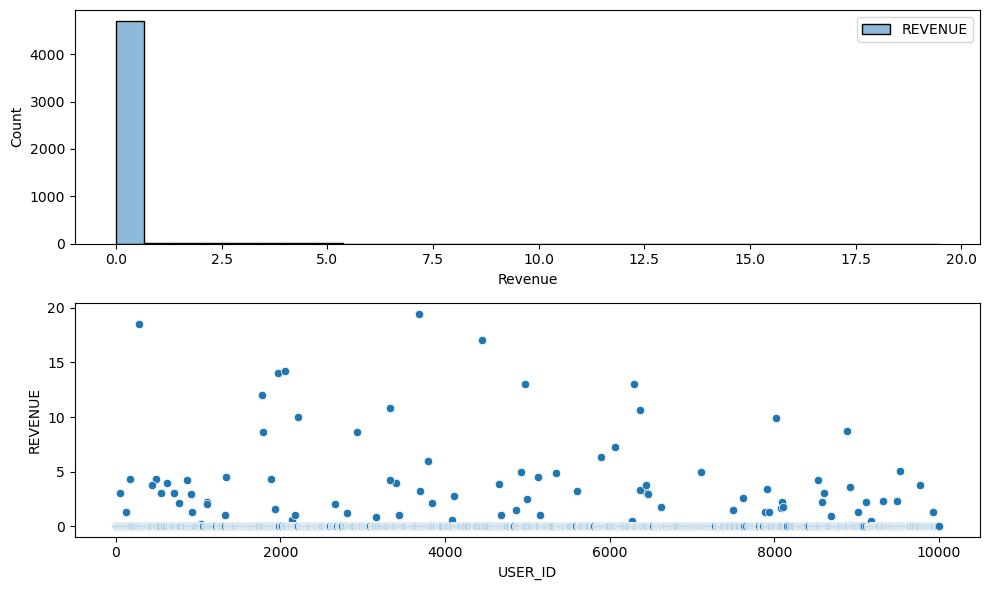

In [70]:
#Sturge’s Rule for number of bins
n_bins = 1 + 3.322*np.log(clean_df.groupby(["VARIANT_NAME","USER_ID"]).agg({"REVENUE":"sum"}).count())

f = plt.figure(figsize=(10,6))

ax1 = f.add_subplot(211)
sns.histplot(clean_df.groupby(["VARIANT_NAME","USER_ID"]).agg({"REVENUE":"sum"}), bins=int(round(n_bins)))
plt.xlabel('Revenue')

ax2 = f.add_subplot(212)
sns.scatterplot(clean_df.groupby(["VARIANT_NAME","USER_ID"]).agg({"REVENUE":"sum"})["REVENUE"].reset_index(), x="USER_ID", y="REVENUE")

plt.tight_layout()
plt.show()

OBS: I'll remove revenues above 20

In [13]:
clean_df = clean_df[clean_df["REVENUE"] < 20]

## Aggregate revenue vector per randomization unit

In [72]:
revenue_per_user = clean_df.groupby(["VARIANT_NAME", "USER_ID"]).agg({"REVENUE": 'sum'}).reset_index()
revenue_per_control_user = revenue_per_user[revenue_per_user["VARIANT_NAME"] == 'control']["REVENUE"]
revenue_per_variant_user = revenue_per_user[revenue_per_user["VARIANT_NAME"] == 'variant']["REVENUE"]

## <b> Power Analysis </b>

In [73]:
power_analysis = TTestIndPower()

sample_size_1 = power_analysis.solve_power(effect_size = 0.01, alpha = 0.05, power = 0.8, alternative = 'two-sided')
sample_size_10 = power_analysis.solve_power(effect_size = 0.1, alpha = 0.05, power = 0.8, alternative = 'two-sided')

print("The sample size needed for each group to detect an effect size of 1% is {}".format(round(sample_size_1)))
print("The sample size needed for each group to detect an effect size of 10% is {}".format(round(sample_size_10)))

The sample size needed for each group to detect an effect size of 1% is 156978
The sample size needed for each group to detect an effect size of 10% is 1571


/Users/ssotomayorba/miniconda3/envs/micromaster/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Users/ssotomayorba/miniconda3/envs/micromaster/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: invalid value encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/Users/ssotomayorba/miniconda3/envs/micromaster/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Users/ssotomayorba/miniconda3/envs/micromaster/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


In [16]:
# Another option
# Van Belle (2002) formula
revenue_per_control_user = revenue_per_user[revenue_per_user["VARIANT_NAME"] == 'control']["REVENUE"]
count_control = int(revenue_per_control_user.count())
mean_control = float(revenue_per_control_user.mean())
std_control = float(revenue_per_control_user.std())
mde = 0.01

print('Users per variant to detect a {}% effect: {}'.format(100*mde, round(16*(std_control)**2/(mde*mean_control)**2)))
print('Total users to detect a {}% effect: {}'.format(100*mde, round(2*16*(std_control)**2/(mde*mean_control)**2)))

Users per variant to detect a 1.0% effect: 14897067
Total users to detect a 1.0% effect: 29794134


In [17]:
# More conservative approach
# Wheeler formula (1974)
print('Users per variant to detect a {}% effect: {}'.format(100*mde, round((4*2*std_control/mde*mean_control)**2)))
print('Total users to detect a {}% effect: {}'.format(100*mde, round(2*(4*2*std_control/mde*mean_control)**2)))

Users per variant to detect a 1.0% effect: 4702
Total users to detect a 1.0% effect: 9404


## </b> Impact of the test variant in mean and median </b>

In [18]:
#Check for Normality
norm_control = shapiro(revenue_per_control_user)[1]
norm_variant = shapiro(revenue_per_variant_user)[1]

if (norm_control > 0.05) & (norm_variant > 0.05):
    
    #Check homogeneity: bartlett for non-normal distributions
    homogeneity = bartlett(revenue_per_control_user, revenue_per_variant_user)
    
    if homogeneity < 0.05:
        #Normal but different variances: Welch's t-test
        p_value = ttest_ind(revenue_per_control_user, revenue_per_variant_user, equal_var=False, alternative='two-sided')[1]
    else:
        #Normal but same variance
        p_value = ttest_ind(revenue_per_control_user, revenue_per_variant_user, equal_var=True, alternative='two-sided')[1]
else:
    # Non normal distribution
    p_value = mannwhitneyu(revenue_per_control_user, revenue_per_variant_user, alternative='two-sided')[1]

if p_value < 0.05: print('With a pvalue of {}, there is enough evidence to reject the null hypothesis. Control and variant means are different.'.format(round(p_value, 2)))
else: print('With a pvalue of {}, there is not enough evidence to reject the null hypothesis. Can not tell if the control and variant means are different.'.format(round(p_value, 2)))

With a pvalue of 0.29, there is not enough evidence to reject the null hypothesis. Can't tell if the control and variant means are different.


In [19]:
p_value_median = median_test(revenue_per_control_user, revenue_per_variant_user).pvalue
if p_value_median < 0.05: print('With a pvalue of {}, there is enough evidence to reject the null hypothesis. Control and variant medians are different.'.format(round(p_value_median, 2)))
else: print('With a pvalue of {}, there is not enough evidence to reject the null hypothesis. Can not tell if the control and variant medians are different.'.format(round(p_value_median, 2)))

With a pvalue of 0.34, there is not enough evidence to reject the null hypothesis. Can't tell if the control and variant medians are different.


In [74]:
df = revenue_per_user[["REVENUE", "VARIANT_NAME"]]
bootstrap_sample_size = len(df) 

mean_diffs = []
median_diffs = []
for i in range(100):
    bootstrap_sample = df.sample(n = bootstrap_sample_size, replace = True)
    mean_diff = bootstrap_sample[bootstrap_sample["VARIANT_NAME"] == 'variant'].mean(numeric_only=True) - bootstrap_sample[bootstrap_sample["VARIANT_NAME"] == 'control'].mean(numeric_only=True)
    median_diff = bootstrap_sample[bootstrap_sample["VARIANT_NAME"] == 'variant'].median(numeric_only=True) - bootstrap_sample[bootstrap_sample["VARIANT_NAME"] == 'control'].median(numeric_only=True)
    mean_diffs.append(mean_diff)
    median_diffs.append(median_diff)

# Mean confidence interval for alpha=0.05
lower_ci_mean = np.percentile(mean_diffs, 2.5)
upper_ci_mean = np.percentile(mean_diffs, 97.5)

# Median confidence interval for alpha=0.05
lower_ci_median = np.percentile(median_diffs, 2.5)
upper_ci_median = np.percentile(median_diffs, 97.5)

# Mean Point estimate
point_est_mean = df[df["VARIANT_NAME"] == 'variant'].mean(numeric_only=True) - df[df["VARIANT_NAME"] == 'control'].mean(numeric_only=True)
print('Point estimate of difference between means:', round(float(point_est_mean), 3))
print('95% confidence interval for the difference between means:', (round(lower_ci_mean,3), round(upper_ci_mean,3)),' this is base on 100 repetitions')

# Median Point estimate
point_est_median = df[df["VARIANT_NAME"] == 'variant'].median(numeric_only=True) - df[df["VARIANT_NAME"] == 'control'].median(numeric_only=True)
print('Point estimate of difference between means:', round(float(point_est_median), 3))
print('95% confidence interval for the difference between means:', (round(lower_ci_median,3), round(upper_ci_median,3)),' this is base on 100 repetitions')

columns = ['metric', 'lift', 'lower_ci', 'upper_ci']
output_df = pd.DataFrame(data=[['mean', float(point_est_mean), lower_ci_mean, upper_ci_mean], ['median', float(point_est_median), lower_ci_median, upper_ci_median]], columns=columns)
display(output_df)

Point estimate of difference between means: -0.029
95% confidence interval for the difference between means: (-0.068, 0.015)  this is base on 100 repetitions
Point estimate of difference between means: 0.0
95% confidence interval for the difference between means: (0.0, 0.0)  this is base on 100 repetitions


,metric,lift,lower_ci,upper_ci
0,mean,-0.028914,-0.067547,0.015467
1,median,0.000000,0.000000,0.000000


<ErrorbarContainer object of 3 artists>

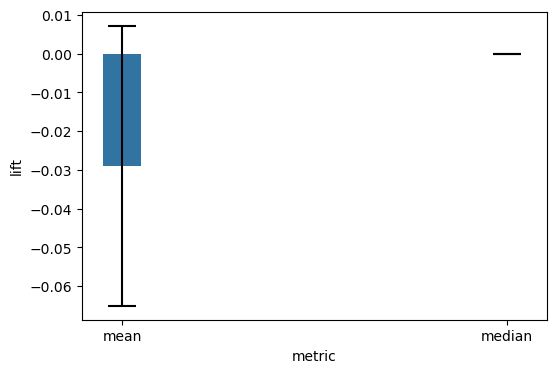

In [21]:
f = plt.figure(figsize=(6,4))

ax = f.add_subplot(111)
sns.barplot(data = output_df, x= "metric", y="lift", width=0.1)
plt.errorbar(x=output_df.index, y=output_df["lift"].values, yerr=(output_df["upper_ci"]-output_df["lower_ci"])/2, 
             fmt='none', ecolor='black', capsize=10, capthick=1.5)

## Another alternative to see the impact of the variant in revenue through linear reg coefficients

In [61]:
# Create dummy variable for the variant

encoded_df = pd.get_dummies(
    data = revenue_per_user,
    prefix = 'dummy',
    prefix_sep='_',
    columns = ["VARIANT_NAME"],
    drop_first =True,
    dtype='int8'
)

encoded_df.head()

,USER_ID,REVENUE,dummy_variant
0,2,0.0,0
1,11,0.0,0
2,12,0.0,0
3,13,0.0,0
4,21,0.0,0


In [60]:
X = sm.add_constant(encoded_df.drop(columns=["USER_ID", "REVENUE"]))
y = encoded_df["REVENUE"]

OLS = sm.OLS(y, X)
estimation_results = OLS.fit()
estimation_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                REVENUE   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.488
Date:                Fri, 31 Mar 2023   Prob (F-statistic):              0.223
Time:                        12:23:34   Log-Likelihood:                -5831.0
No. Observations:                4781   AIC:                         1.167e+04
Df Residuals:                    4779   BIC:                         1.168e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0942      0.017      5.622      0.000       0.061       0.127
dummy_variant    -0.0289      0.024     -1.220      0.223      -0.075       0.018
==============================================================================
Omnibus:                     9129.454   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13745242.795
Skew:                          14.846   Prob(JB):                         0.00
Kurtosis:                     263.994   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
estimation_results.conf_int(alpha=0.05)

,0,1
const,0.061380,0.127117
dummy_variant,-0.075382,0.017554


## Once again we can see that we can't reject the null hypothesis wih a 95% of confidence. The confidence interval of the dummy variant coefficient include the 0.